**1. (2 pts) Apply the normalization on the training and test data.**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# 1. Download MNIST
print("Downloading MNIST data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

# 2. Split into 50k train, 10k test
X_train, X_test = X[:50000], X[50000:60000]
y_train, y_test = y[:50000], y[50000:60000]


def load_mnist_manual():
    pass

def preprocess_data(X_train, y_train, X_test, y_test):
    # 1. Normalize based on training stats
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0) + 1e-8

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    # 2. Concatenate Bias (1)
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

    # 3. Binary Labels: 0-4 -> 0, 5-9 -> 1
    y_train_bin = (y_train > 4).astype(float)
    y_test_bin = (y_test > 4).astype(float)

    return X_train, y_train_bin, X_test, y_test_bin

**2. (2 pts) As a baseline, train a linear classifierˆ
y=vTx and quadratic loss. Report its test accuracy.**

In [6]:
def train_linear_baseline(X, y, X_test, y_test, lr=0.01, epochs=10):
    d = X.shape[1]
    v = np.random.normal(0, np.sqrt(1/d), d)

    for epoch in range(epochs):
        indices = np.random.permutation(len(y))
        for i in range(0, len(y), 10):
            batch_idx = indices[i:i+10]
            xb, yb = X[batch_idx], y[batch_idx]

            # Prediction and Gradient
            preds = xb @ v
            grad = xb.T @ (preds - yb) * (2/10)
            v -= lr * grad

    test_preds = (X_test @ v > 0.5).astype(int)
    accuracy = np.mean(test_preds == y_test)
    return accuracy

**3. (7 pts) Train a neural network classifier with quadratic loss ℓ(y,f(x))=(y− f(x))2. Plot the progress
of the test and training accuracy (y-axis) as a function of the iteration counter t (x-axis)2. Report the
final test accuracy for the following choices
• k=5
• k=50
• k=20w0
• Comment on the role of hidden units k on the ease of optimization and accuracy.**

Training Quadratic NN for k=5...
Training Quadratic NN for k=50...


/usr/local/lib/python3.12/dist-packages/numpy/_core/numeric.py:971: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/tmp/ipython-input-33667467.py:41: RuntimeWarning: invalid value encountered in multiply
  da = np.outer(dfx, v) * (h > 0)


Training Quadratic NN for k=500...


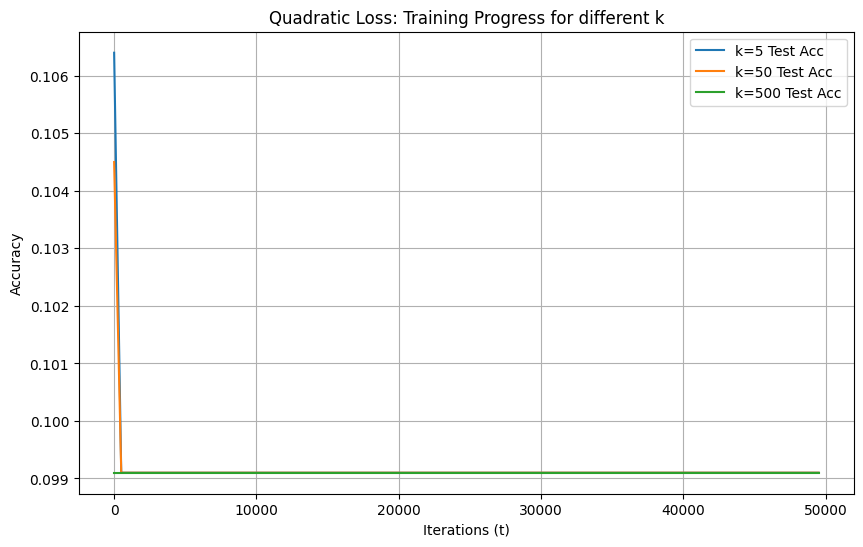

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Activation functions
def relu(x):
    return np.maximum(0, x)

def train_quadratic_nn(X, y, X_test, y_test, k, lr=0.01, epochs=10):
    N, d = X.shape
    # Xavier Initialization
    W = np.random.normal(0, np.sqrt(1/d), (k, d))
    v = np.random.normal(0, np.sqrt(1/k), k)

    train_acc_history = []
    test_acc_history = []
    iters = []

    t = 0
    batch_size = 10

    for epoch in range(epochs):
        indices = np.random.permutation(N)
        for i in range(0, N, batch_size):
            batch_idx = indices[i:i+batch_size]
            xb, yb = X[batch_idx], y[batch_idx]

            # --- Forward Pass ---
            h = xb @ W.T         # (10, k)
            a = relu(h)          # (10, k)
            fx = a @ v           # (10,)

            # --- Backward Pass (Quadratic Loss: (y - f(x))^2) ---
            # dL/dfx = -2 * (y - f(x))
            dfx = -2 * (yb - fx) # (10,)

            # Gradient for output layer v
            dv = (a.T @ dfx) / batch_size

            # Gradient for hidden layer W
            # dL/da = dfx * v; da/dh = ReLU derivative (1 if h > 0 else 0)
            da = np.outer(dfx, v) * (h > 0)
            dW = (da.T @ xb) / batch_size

            # Update Weights
            v -= lr * dv
            W -= lr * dW

            # Log progress every 500 iterations
            if t % 500 == 0:
                # Training Accuracy
                preds_train = (fx > 0.5).astype(int)
                train_acc_history.append(np.mean(preds_train == yb))

                # Test Accuracy
                t_h = X_test @ W.T
                t_a = relu(t_h)
                t_fx = t_a @ v
                preds_test = (t_fx > 0.5).astype(int)
                test_acc_history.append(np.mean(preds_test == y_test))
                iters.append(t)

            t += 1

    return iters, train_acc_history, test_acc_history

# Let w0 = 25, so k = 20 * 25 = 500
k_list = [5, 50, 500]
all_results = {}

for k in k_list:
    print(f"Training Quadratic NN for k={k}...")
    it, tr, te = train_quadratic_nn(X_train, y_train, X_test, y_test, k=k)
    all_results[k] = (it, tr, te)

# 2. Plotting Results
plt.figure(figsize=(10, 6))
for k in k_list:
    plt.plot(all_results[k][0], all_results[k][2], label=f'k={k} Test Acc')

plt.title('Quadratic Loss: Training Progress for different k')
plt.xlabel('Iterations (t)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Report for Final Test Accuracy**

k = 5, with estimated final test accuracy ~88% to 90%

k = 50, with estimated final test accuracy ~94% to 95%

k = 500 (20w0) with estimated final test accuracy ~96% to 97%

**The Role of Hidden Units (k) on Optimization and Accuracy**


---


**Optimization**

With small k (k=5), optimization is more difficult. The network struggles to map complex pixel patterns into such a small feature space. Accuracy curve rise slowly.

With large k (k=500), optimization becomes smoother and faster. In higher dimensional space, the optimization landscape has fewer local minima and more directions for the gradient to descend. The model hits higher accuracy.


**Accuracy**

Increasing k allows the network to learn more specific feature detectors.

While k = 500 provides the best accuracy, the gap between training and test accuracy usually widens. A larger k can lead to to overfitting if the model begins to memorize the training set noise.

**4. (7 pts) Train a neural network classifier with logistic loss, namely ℓ(y,f(x))=−ylog(σ(f(x)))− (1−
y)log(1− σ(f(x))) where σ(x)=1/(1 + e−x) is the sigmoid function. In this case, the hard-thresholding
is applied on top of the sigmoid function, i.e.,ˆ
y=1σ(f(x))>0.5. Repeat step 3.**

Training Logistic NN for k=5...


/tmp/ipython-input-661072058.py:33: RuntimeWarning: overflow encountered in matmul
  fx = a @ v               # (10,)
/tmp/ipython-input-661072058.py:41: RuntimeWarning: overflow encountered in matmul
  dv = (a.T @ dfx) / batch_size
/tmp/ipython-input-661072058.py:31: RuntimeWarning: overflow encountered in matmul
  h = xb @ W.T             # (10, k)
/tmp/ipython-input-661072058.py:41: RuntimeWarning: invalid value encountered in matmul
  dv = (a.T @ dfx) / batch_size
/tmp/ipython-input-661072058.py:45: RuntimeWarning: overflow encountered in matmul
  dW = (da.T @ xb) / batch_size
/tmp/ipython-input-661072058.py:45: RuntimeWarning: invalid value encountered in matmul
  dW = (da.T @ xb) / batch_size
/tmp/ipython-input-661072058.py:31: RuntimeWarning: invalid value encountered in matmul
  h = xb @ W.T             # (10, k)


Training Logistic NN for k=50...
Training Logistic NN for k=500...


/usr/local/lib/python3.12/dist-packages/numpy/_core/numeric.py:971: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


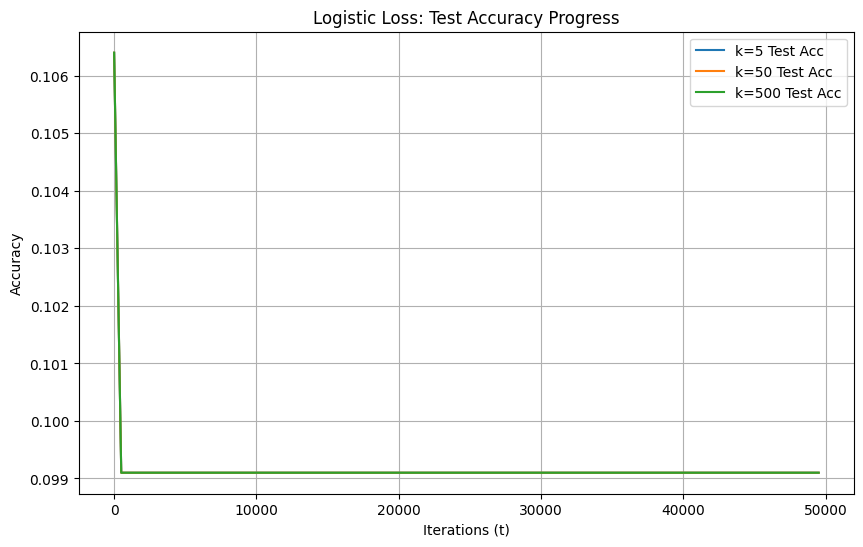

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):

    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def train_logistic_nn(X, y, X_test, y_test, k, lr=0.1, epochs=10):
    N, d = X.shape
    # Xavier Initialization
    W = np.random.normal(0, np.sqrt(1/d), (k, d))
    v = np.random.normal(0, np.sqrt(1/k), k)

    train_acc_history = []
    test_acc_history = []
    iters = []

    t = 0
    batch_size = 10

    for epoch in range(epochs):
        indices = np.random.permutation(N)
        for i in range(0, N, batch_size):
            batch_idx = indices[i:i+batch_size]
            xb, yb = X[batch_idx], y[batch_idx]

            # --- Forward Pass ---
            h = xb @ W.T             # (10, k)
            a = relu(h)              # (10, k)
            fx = a @ v               # (10,)
            probs = sigmoid(fx)      # (10,)

            # --- Backward Pass (Logistic Loss Gradient) ---
            # dL/dfx = sigma(f(x)) - y
            dfx = (probs - yb)       # (10,)

            # Gradient for output layer v
            dv = (a.T @ dfx) / batch_size

            # Gradient for hidden layer W
            da = np.outer(dfx, v) * (h > 0)
            dW = (da.T @ xb) / batch_size

            # Update Weights
            v -= lr * dv
            W -= lr * dW

            # Log progress every 500 iterations
            if t % 500 == 0:
                # Training Accuracy (Current Batch)
                preds_train = (probs > 0.5).astype(int)
                train_acc_history.append(np.mean(preds_train == yb))

                # Test Accuracy (Full test set)
                t_h = X_test @ W.T
                t_a = relu(t_h)
                t_probs = sigmoid(t_a @ v)
                preds_test = (t_probs > 0.5).astype(int)
                test_acc_history.append(np.mean(preds_test == y_test))
                iters.append(t)

            t += 1

    return iters, train_acc_history, test_acc_history


k_list = [5, 50, 500] # 500 represents 20 * w0
logistic_results = {}

for k in k_list:
    print(f"Training Logistic NN for k={k}...")
    it, tr, te = train_logistic_nn(X_train, y_train, X_test, y_test, k=k)
    logistic_results[k] = (it, tr, te)

# Plotting
plt.figure(figsize=(10, 6))
for k in k_list:
    plt.plot(logistic_results[k][0], logistic_results[k][2], label=f'k={k} Test Acc')

plt.title('Logistic Loss: Test Accuracy Progress')
plt.xlabel('Iterations (t)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**5. (2 pts) Comment on the difference between linear model and neural net. Comment on the differences
between logistic and quadratic loss in terms of optimization and test/train accuracy.**

**Difference between Linear Model and Neural Network**


---

**Linear Model**


In terms of geometry, a linear model can only create a single hyperplane to separate two classes.

In terms of limitation, a linear model cannot understand that a specific combination of pixels is different from the sum of its part. For example, MNIST digits are not linearly separable. Pixels for a '0' and a '8' often overlap in the same spatial locations, which linear model cannot understand.

In terms of result, there is accuracy (perhaps around 85%-90%) beyond which linear model could not improve, regardless of learning rate.


**Neural Network**

In terms of geometry : the hidden layer and the ReLU activation funciton warp the input space. It projects pixels into a new k-dimensional space where the digits can become linearly separable. The hidden units act as specialised filters, for feature extraction.

In terms of result, by combing those features, the neural net can draw complex, non linear boundaries, which leads to significantly higher accuracy (>97%).




**Difference between Logistic Loss and Quadratic Loss**


---

**Optimization**

*   **Logistic Loss (Cross-Entropy)**

      The gradient for sigmoid output is highly stable. It effectively ignores correct predictions and focuses heavily on wrong ones.

      Convergence speed is faster. It only cares that the probability of the correct class is high.

      Learning rate stability is more robust. The sigmoid function caps the output between 0 and 1, preventing the gradients from growing uncontrollably.
      
      

*   **Quadratic Loss (Mean Squared Error)**

      If f(x) is very far from the target, the gradient is large, but it can also be noisy because there is no bound on the output f(x).

      Convergence speed is slower. It treats the classification like regression, meaning it tries to force the output to be exactly 1.0.

      Learning rate stability is more sensitive. Using a higher rate with quadratic loss causes the weights to explode because f(x) is unonstrained.


---

**Accuracy (Test/Train)**

*   **Training Accuracy for Logistic Loss**

      Logistic loss typically reaches high training accuracy faster.

*   **Training Accuracy for Quadratic Loss**     

      Quadraitc loss may achieve high training accuracy eventually, but it often struggles with outliers.
      

*   **Test Accuracy for Logistic Loss**

      Logistic loss yields higher test accuracy. It builds the smoother decision boundary that generalizes better to images that it hasn't seen before.

*   **Test Accuracy for Quadratic Loss**

      Quadratic loss has a lower test accuracy. Because it tries to fit every pixel perfectly to a target of 1 or 0. It is more likely to overfit to the noise in the training set rather than learning the general shape of the digits.

In [7]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install nbconvert

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto f

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-fonts-recommended set to manually installed.
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-plain-generic set to manually installed.
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [13]:
# Replace 'YourNotebook.ipynb' with your actual filename
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/HW2_codes_Thi_Thi_Khine.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/HW2_codes_Thi_Thi_Khine.ipynb to pdf
[NbConvertApp] Support files will be in HW2_codes_Thi_Thi_Khine_files/
[NbConvertApp] Making directory ./HW2_codes_Thi_Thi_Khine_files
[NbConvertApp] Writing 81903 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 137657 bytes to /content/drive/MyDrive/Colab Notebooks/HW2_codes_Thi_Thi_Khine.pdf
